In [1]:
from pathlib import Path
import os

# DATA ROOT CONFIGURATION
# --------------------------------------------------
# Preferred usage:
#   Set an environment variable named BAP_DATA_ROOT
#   to point to the dataset directory on your machine.
#
# Example:
#   Windows (PowerShell):
#     setx BAP_DATA_ROOT "C:\path\to\Hanna Hammock"
#
#   macOS / Linux:
#     export BAP_DATA_ROOT="/path/to/Hanna Hammock"
#
# DEFAULT_DATA_ROOT below is a local fallback
# for development/testing purposes only.
# --------------------------------------------------

ENV_KEY = "BAP_DATA_ROOT"
DEFAULT_DATA_ROOT = r"C:\Users\zeynu\Downloads\archive\Hanna Hammock"

ANA_KLASOR = Path(os.environ.get(ENV_KEY, DEFAULT_DATA_ROOT))
OUT_ROOT = ANA_KLASOR / "_outputs"
OUT_ROOT.mkdir(parents=True, exist_ok=True)

ESIK = 200  # °C

print("ANA_KLASOR:", ANA_KLASOR)
print("exists:", ANA_KLASOR.exists())
print("OUT_ROOT:", OUT_ROOT)
print("ESIK:", ESIK)

ANA_KLASOR: C:\Users\zeynu\Downloads\archive\Hanna Hammock
exists: True
OUT_ROOT: C:\Users\zeynu\Downloads\archive\Hanna Hammock\_outputs
ESIK: 200


In [2]:
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling

def match_to_ref_grid(src_path, ref_profile, resampling=Resampling.bilinear):
    """src_path'i ref_profile (crs/transform/shape)'e uydurup 1 band döndürür."""
    with rasterio.open(src_path) as src:
        src_arr = src.read(1).astype(np.float32)

        dst = np.empty((ref_profile["height"], ref_profile["width"]), dtype=np.float32)

        reproject(
            source=src_arr,
            destination=dst,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref_profile["transform"],
            dst_crs=ref_profile["crs"],
            resampling=resampling,
        )

    return dst

def fuse_rgb_thermal(rgb_path, thermal_path, out_path):
    """RGB(3 band) + thermal(1 band) => 4 band GeoTIFF (RGBT). Thermal, RGB grid'ine hizalanır."""
    with rasterio.open(rgb_path) as rgb_src:
        rgb = rgb_src.read([1,2,3]).astype(np.float32)  # (3,H,W)
        profile = rgb_src.profile.copy()
        profile.update(count=4, dtype="float32")

    thermal_aligned = match_to_ref_grid(thermal_path, profile)  # (H,W)

    stack4 = np.concatenate([rgb, thermal_aligned[None, :, :]], axis=0)  # (4,H,W)

    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(stack4)

    return out_path

In [3]:
import rasterio
from pathlib import Path

klasor_yolu = ANA_KLASOR / "plot 1" / "duringburn" / "geo_thermal_tiff_celsius"

dosya_listesi = sorted(
    list(klasor_yolu.glob("*.tif")) +
    list(klasor_yolu.glob("*.tiff")) +
    list(klasor_yolu.glob("*.TIF")) +
    list(klasor_yolu.glob("*.TIFF"))
)

print("Klasör:", klasor_yolu)
print("Var mı?:", klasor_yolu.exists())
print(f"Toplam {len(dosya_listesi)} adet termal dosya bulundu!")
print("İlk 5 dosya:", [p.name for p in dosya_listesi[:5]])

max_sicakliklar = []
print("Dosyalar taranıyor...")

for p in dosya_listesi:
    with rasterio.open(p) as src:
        veri = src.read(1)
        max_sicakliklar.append(float(veri.max()))

print("Tarama bitti!")
print("Min/Max (max_sicaklik):", min(max_sicakliklar), max(max_sicakliklar))


Klasör: C:\Users\zeynu\Downloads\archive\Hanna Hammock\plot 1\duringburn\geo_thermal_tiff_celsius
Var mı?: True
Toplam 592 adet termal dosya bulundu!
İlk 5 dosya: ['IRX_0529_ref_geo.TIFF', 'IRX_0529_ref_geo.TIFF', 'IRX_0530_ref_geo.TIFF', 'IRX_0530_ref_geo.TIFF', 'IRX_0531_ref_geo.TIFF']
Dosyalar taranıyor...
Tarama bitti!
Min/Max (max_sicaklik): 197.0 604.5999755859375


In [4]:
from pathlib import Path

def find_plot_root(path: Path) -> Path:
    for p in path.parents:
        if p.is_dir() and p.name.lower().startswith("plot"):
            return p
    raise ValueError(f"Plot root bulunamadı: {path}")

def list_thermal_dirs(plot_root: Path):
    # plot içinde neredeyse thermal dirleri bul
    return sorted([d for d in plot_root.rglob("geo_thermal_tiff_celsius") if d.is_dir()])

def list_tiffs(d: Path):
    return (
        sorted(d.rglob("*.tif")) +
        sorted(d.rglob("*.tiff")) +
        sorted(d.rglob("*.TIF")) +
        sorted(d.rglob("*.TIFF"))
    )

rgb_list = sorted(ANA_KLASOR.rglob("*_ortho.tif"))
print("RGB ortho sayısı:", len(rgb_list))

# 1) RGB'ler arasında, kendi plot'u içinde thermal bulabilen ilkini seç
picked = None
for rgb_path in rgb_list:
    plot_root = find_plot_root(rgb_path)
    tdirs = list_thermal_dirs(plot_root)
    if len(tdirs) == 0:
        continue

    # RGB'nin stage'i ile aynı stage'de thermal var mı diye dene:
    stage = rgb_path.parent.name
    same_stage_dir = plot_root / stage / "geo_thermal_tiff_celsius"
    if same_stage_dir.exists():
        tiffs = list_tiffs(same_stage_dir)
        if len(tiffs) > 0:
            picked = (rgb_path, same_stage_dir, tiffs[0])
            break

# Eğer stage eşleşmesi bulunamazsa: sadece plot içindeki ilk thermal dir'i al (ama raporla)
fallback_used = False
if picked is None:
    for rgb_path in rgb_list:
        plot_root = find_plot_root(rgb_path)
        tdirs = list_thermal_dirs(plot_root)
        if len(tdirs) == 0:
            continue
        tiffs = list_tiffs(tdirs[0])
        if len(tiffs) == 0:
            continue
        picked = (rgb_path, tdirs[0], tiffs[0])
        fallback_used = True
        break

if picked is None:
    raise FileNotFoundError("Hiçbir plot içinde geo_thermal_tiff_celsius + tif bulunamadı.")

rgb_path, thermal_dir, thermal_path = picked
plot_root = find_plot_root(rgb_path)
stage = rgb_path.parent.name

print("Seçilen RGB:", rgb_path)
print("Plot:", plot_root.name)
print("Stage (RGB'nin klasörü):", stage)
print("Seçilen thermal klasörü:", thermal_dir)
print("Seçilen thermal:", thermal_path)
print("Fallback kullanıldı mı?:", fallback_used)

# 2) çıktı
aligned_dir = OUT_ROOT / "aligned_fused" / plot_root.name / stage
aligned_dir.mkdir(parents=True, exist_ok=True)

out_path = aligned_dir / f"{rgb_path.stem}__{thermal_path.stem}_RGBT.tif"
print("Yazılacak:", out_path)

fuse_rgb_thermal(rgb_path, thermal_path, out_path)
print("BİTTİ ✅", out_path)
# NOTE: The post-burn stage is excluded from RGB–Thermal fusion in this notebook.

RGB ortho sayısı: 4
Seçilen RGB: C:\Users\zeynu\Downloads\archive\Hanna Hammock\plot 1\postburn\plot1_postburn_ortho.tif
Plot: plot 1
Stage (RGB'nin klasörü): postburn
Seçilen thermal klasörü: C:\Users\zeynu\Downloads\archive\Hanna Hammock\plot 1\duringburn\geo_thermal_tiff_celsius
Seçilen thermal: C:\Users\zeynu\Downloads\archive\Hanna Hammock\plot 1\duringburn\geo_thermal_tiff_celsius\IRX_0529_ref_geo.TIFF
Fallback kullanıldı mı?: True
Yazılacak: C:\Users\zeynu\Downloads\archive\Hanna Hammock\_outputs\aligned_fused\plot 1\postburn\plot1_postburn_ortho__IRX_0529_ref_geo_RGBT.tif
BİTTİ ✅ C:\Users\zeynu\Downloads\archive\Hanna Hammock\_outputs\aligned_fused\plot 1\postburn\plot1_postburn_ortho__IRX_0529_ref_geo_RGBT.tif


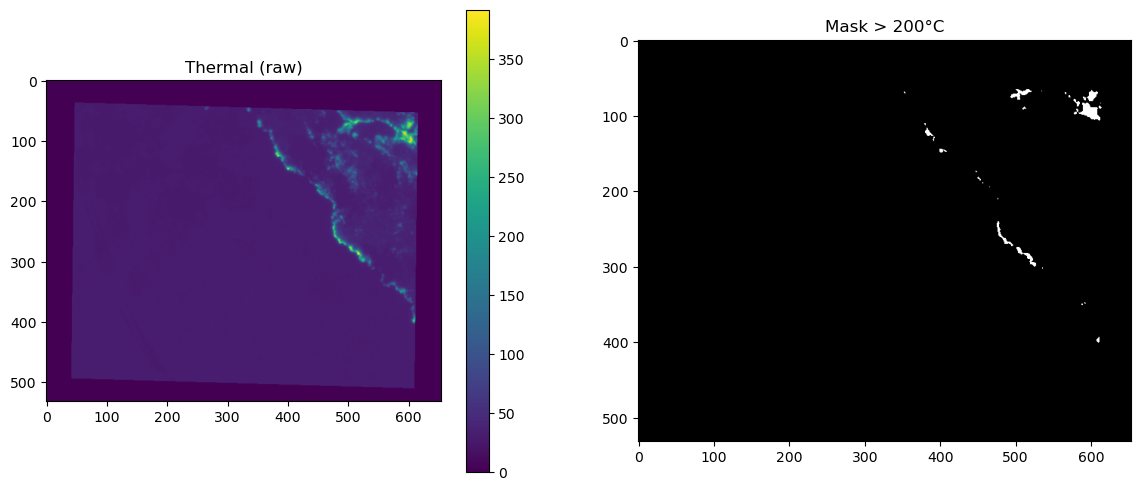

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio

secilen_dosya = dosya_listesi[150]   
tam_yol = secilen_dosya

esik_degeri = 200

with rasterio.open(tam_yol) as src:
    veri = src.read(1)
    yangin_maskesi = (veri > esik_degeri).astype(np.uint8)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.title("Thermal (raw)")
plt.imshow(veri)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title(f"Mask > {esik_degeri}°C")
plt.imshow(yangin_maskesi, cmap="gray")
plt.show()


In [6]:
import os
import rasterio
import numpy as np
import cv2
from pathlib import Path

ana_klasor = ANA_KLASOR
cikti_ana_dizin = OUT_ROOT / "Tum_Maskeler"
cikti_ana_dizin.mkdir(parents=True, exist_ok=True)

esik_degeri = 200

print("Tüm veri seti taranıyor ve işleniyor...")

sayac = 0
islenen_klasor_sayisi = 0

for kok, alt_klasorler, dosyalar in os.walk(ana_klasor, topdown=True):
    # _outputs'u taramadan çıkar (sonsuz büyümeyi engeller)
    alt_klasorler[:] = [d for d in alt_klasorler if d != "_outputs"]

    if "geo_thermal_tiff_celsius" not in kok:
        continue

    kok_path = Path(kok)
    goreli_yol = kok_path.relative_to(ana_klasor)
    kayit_yeri = cikti_ana_dizin / goreli_yol
    kayit_yeri.mkdir(parents=True, exist_ok=True)

    tiff_listesi = [f for f in dosyalar if f.lower().endswith((".tif", ".tiff", ".tiff"))]

    print(f"İşleniyor: {goreli_yol} ({len(tiff_listesi)} dosya)")
    islenen_klasor_sayisi += 1

    for f in tiff_listesi:
        tif_path = kok_path / f
        with rasterio.open(tif_path) as src:
            veri = src.read(1)

        maske = (veri > esik_degeri).astype(np.uint8) * 255

        out_png = kayit_yeri / f"{tif_path.stem}_mask.png"
        cv2.imwrite(str(out_png), maske)
        sayac += 1

print("\nİşlem TAMAMLANDI!")
print(f"Toplam maske üretilen TIFF sayısı: {sayac}")
print(f"Maskeler '{cikti_ana_dizin}' klasöründe toplandı.")
print(f"İşlenen klasör sayısı: {islenen_klasor_sayisi}")


Tüm veri seti taranıyor ve işleniyor...
İşleniyor: plot 1\duringburn\geo_thermal_tiff_celsius (296 dosya)
İşleniyor: plot 2\duringburn\geo_thermal_tiff_celsius (0 dosya)
İşleniyor: plot 2\duringburn\geo_thermal_tiff_celsius\part1 (322 dosya)
İşleniyor: plot 2\duringburn\geo_thermal_tiff_celsius\part2 (176 dosya)

İşlem TAMAMLANDI!
Toplam maske üretilen TIFF sayısı: 794
Maskeler 'C:\Users\zeynu\Downloads\archive\Hanna Hammock\_outputs\Tum_Maskeler' klasöründe toplandı.
İşlenen klasör sayısı: 4


In [13]:
import os
import rasterio
import numpy as np
import cv2
from pathlib import Path

ana_dizin = ANA_KLASOR
cikti_gorsel_dizini = OUT_ROOT / "Normalize_Goruntuler"
cikti_gorsel_dizini.mkdir(parents=True, exist_ok=True)

print("Normalizasyon ve PNG dönüştürme işlemi başlıyor...")

sayac = 0
islenen_klasor_sayisi = 0

for kok, alt_klasorler, dosyalar in os.walk(ana_dizin, topdown=True):
    # kritik: _outputs'u taramadan çıkar (sonsuz büyümeyi engeller)
    alt_klasorler[:] = [d for d in alt_klasorler if d != "_outputs"]

    if "geo_thermal_tiff_celsius" not in kok:
        continue

    kok_path = Path(kok)
    goreli_yol = kok_path.relative_to(ana_dizin)
    kayit_yeri = cikti_gorsel_dizini / goreli_yol
    kayit_yeri.mkdir(parents=True, exist_ok=True)

    tiff_listesi = [f for f in dosyalar if f.lower().endswith((".tif", ".tiff", ".tif"))]

  
    print(f"İşleniyor: {goreli_yol} ({len(tiff_listesi)} dosya)")
    islenen_klasor_sayisi += 1

    for f in tiff_listesi:
        tif_path = kok_path / f

        with rasterio.open(tif_path) as src:
            veri = src.read(1).astype(np.float32)

        vmin, vmax = float(np.nanmin(veri)), float(np.nanmax(veri))
        if vmax > vmin:
            norm = (veri - vmin) / (vmax - vmin)
        else:
            norm = np.zeros_like(veri, dtype=np.float32)

        img8 = (norm * 255).clip(0, 255).astype(np.uint8)

        out_png = kayit_yeri / f"{tif_path.stem}.png"   # istersen _norm ekleyebiliriz
        cv2.imwrite(str(out_png), img8)

        sayac += 1


print("\nİşlem TAMAMLANDI!")
print(f"Toplam normalize edilen TIFF sayısı: {sayac}")
print(f"Normalize görüntüler '{cikti_gorsel_dizini}' klasöründe toplandı.")
print(f"İşlenen klasör sayısı: {islenen_klasor_sayisi}")


Normalizasyon ve PNG dönüştürme işlemi başlıyor...
İşleniyor: plot 1\duringburn\geo_thermal_tiff_celsius (296 dosya)
İşleniyor: plot 2\duringburn\geo_thermal_tiff_celsius (0 dosya)
İşleniyor: plot 2\duringburn\geo_thermal_tiff_celsius\part1 (322 dosya)
İşleniyor: plot 2\duringburn\geo_thermal_tiff_celsius\part2 (176 dosya)

İşlem TAMAMLANDI!
Toplam normalize edilen TIFF sayısı: 794
Normalize görüntüler 'C:\Users\zeynu\Downloads\archive\Hanna Hammock\_outputs\Normalize_Goruntuler' klasöründe toplandı.
İşlenen klasör sayısı: 4
